In [1]:
import pandas as pd
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import ml_trading.machine_learning.util

import logging
import datetime, sys, os

date_strftime_format = '%Y-%m-%d %H:%M:%S'
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.path.join(os.getcwd(), 'credential.json')


from dotenv import load_dotenv
# Load environment variables from .env file
load_dotenv()

logging.basicConfig(stream=sys.stdout, level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    datefmt=date_strftime_format)

from xgboost import plot_importance
import shap

/Users/junlim/venvs/dev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import market_data.util
import market_data.util.time

from market_data.feature.impl.common import SequentialFeatureParam

import market_data.feature.cache_reader
importlib.reload(market_data.feature.cache_reader)

import market_data.machine_learning.cache_ml_data
importlib.reload(market_data.machine_learning.cache_ml_data)

import market_data.ingest.bq.cache

In [45]:
df_raw = market_data.ingest.bq.cache.query_and_cache(
    market_data.ingest.bq.common.DATASET_MODE.OKX, market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE, market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    date_str_from='2024-06-17', date_str_to='2024-06-18')


In [46]:
df_raw

,symbol,open,high,low,close,volume
timestamp,,,,,,
2024-06-17 00:00:00-04:00,BLUR-USDT-SWAP,2.997000e-01,3.000000e-01,2.994000e-01,2.994000e-01,2.200000e+04
2024-06-17 00:00:00-04:00,GRT-USD-SWAP,2.272000e-01,2.272000e-01,2.272000e-01,2.272000e-01,0.000000e+00
2024-06-17 00:00:00-04:00,ENJ-USDT-SWAP,2.126000e-01,2.128000e-01,2.125000e-01,2.125000e-01,5.460000e+03
2024-06-17 00:00:00-04:00,DYDX-USDT-SWAP,1.505000e+00,1.506000e+00,1.502000e+00,1.502000e+00,9.637000e+03
2024-06-17 00:00:00-04:00,WLD-USDT-SWAP,3.351000e+00,3.356000e+00,3.346000e+00,3.346000e+00,2.878900e+04
...,...,...,...,...,...,...
2024-06-17 23:59:00-04:00,LPT-USDT-SWAP,1.848700e+01,1.851300e+01,1.847600e+01,1.851000e+01,9.508000e+02
2024-06-17 23:59:00-04:00,BCH-USDT-SWAP,3.917000e+02,3.919000e+02,3.915000e+02,3.919000e+02,2.687000e+01
2024-06-17 23:59:00-04:00,1INCH-USD-SWAP,3.791000e-01,3.796000e-01,3.791000e-01,3.795000e-01,1.660830e+03


In [7]:
time_range = market_data.util.time.TimeRange(
    date_str_from='2024-01-02', date_str_to='2024-01-03',
    )


import market_data.machine_learning.cache_ml_data
importlib.reload(market_data.machine_learning.cache_ml_data)
ml_data_df = market_data.machine_learning.cache_ml_data.load_cached_ml_data(
    market_data.ingest.bq.common.DATASET_MODE.OKX, market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE, market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    time_range=time_range,
)

2025-05-01 13:11:03 - INFO - No specific features specified, using all available features with default parameters
2025-05-01 13:11:03 - INFO - /Users/junlim/algo_cache/ml_data/ml_data/trading-290017.market_data_okx.by_minute_AGGREGATION_MODE.TAKE_LASTEST/r_price_col-close_r_threshold-0.05/t_forward_periods-2_10_t_sl_values-0_03_t_tp_values-0_03/bollinger,period-20_price-close_std_dev-2.0/btc_features,periods-1_5_15_30_60_120_price-close/ema,periods-5_15_30_60_120_price-close_rel-True/garch,alpha-0.1_beta-0.8_omega-0.1_price-close_type-ann/indicators,autocorr_lag-1_autocorr_window-14_minmax_window-20_price-close_rsi_period-14_zscore_window-20/market_regime,price-close_stats-mean_var_skew_kurt_windows-240_1440_4320/returns,periods-1_5_15_30_60_120_price-close_type-simple/volatility,price-close_type-ann_windows-5_10_20_30_60/volume,obv_zscore-20_price-close_ratio_periods-20_50_100_volume-volume/2024-01-02T00:00:00-0500_2024-01-03T00:00:00-0500.parquet exists.


In [10]:
ml_data_df.columns

Index(['symbol', 'return_1', 'return_5', 'return_15', 'return_30', 'return_60',
       'return_120', 'volatility_5', 'volatility_10', 'volatility_20',
       'volatility_30', 'volatility_60', 'bb_upper', 'bb_middle', 'bb_lower',
       'bb_position', 'bb_width', 'rsi', 'open_close_ratio', 'autocorr_lag1',
       'hl_range_pct', 'close_zscore', 'close_minmax', 'ema_5', 'ema_rel_5',
       'ema_15', 'ema_rel_15', 'ema_30', 'ema_rel_30', 'ema_60', 'ema_rel_60',
       'ema_120', 'ema_rel_120', 'obv_pct_change', 'obv_zscore',
       'volume_ratio_20', 'volume_ratio_50', 'volume_ratio_100',
       'btc_return_1', 'btc_return_5', 'btc_return_15', 'btc_return_30',
       'btc_return_60', 'btc_return_120', 'garch_volatility',
       'label_forward_return_2m', 'label_forward_return_10m',
       'label_long_tp30_sl30_2m', 'label_short_tp30_sl30_2m',
       'label_long_tp30_sl30_10m', 'label_short_tp30_sl30_10m'],
      dtype='object')

In [56]:
time_range = market_data.util.time.TimeRange(
    date_str_from='2024-11-02', date_str_to='2024-12-03',
    )


import market_data.machine_learning.cache_ml_data
importlib.reload(market_data.machine_learning.cache_ml_data)
ml_data_seq_df = market_data.machine_learning.cache_ml_data.load_cached_ml_data(
    market_data.ingest.bq.common.DATASET_MODE.OKX, market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE, market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    time_range=time_range,
    seq_params = SequentialFeatureParam(),
)

2025-04-16 22:32:50 - INFO - No specific features specified, using all available features with default parameters
2025-04-16 22:32:50 - INFO - /Users/junlim/algo_cache/ml_data/ml_data/trading-290017.market_data_okx.by_minute_AGGREGATION_MODE.TAKE_LASTEST/sequence_window-60/r_price_col-close_r_threshold-0.05/t_forward_periods-2_10_t_sl_values-0_03_t_tp_values-0_03/bollinger,period-20_price-close_std_dev-2.0/btc_features,periods-1_5_15_30_60_120_price-close/ema,periods-5_15_30_60_120_price-close_rel-True/garch,alpha-0.1_beta-0.8_omega-0.1_price-close_type-ann/indicators,autocorr_lag-1_autocorr_window-14_minmax_window-20_price-close_rsi_period-14_zscore_window-20/market_regime,price-close_stats-mean_var_skew_kurt_windows-240_1440_4320/returns,periods-1_5_15_30_60_120_price-close_type-simple/volatility,price-close_type-ann_windows-5_10_20_30_60/volume,obv_zscore-20_price-close_ratio_periods-20_50_100_volume-volume/2024-11-02T00:00:00-0400_2024-11-03T00:00:00-0400.parquet exists.
2025-04-16

In [57]:
ml_data_seq_df

,symbol,return_1,return_5,return_15,return_30,return_60,return_120,volatility_5,volatility_10,volatility_20,...,btc_return_30,btc_return_60,btc_return_120,garch_volatility,label_forward_return_2m,label_forward_return_10m,label_long_tp30_sl30_2m,label_short_tp30_sl30_2m,label_long_tp30_sl30_10m,label_short_tp30_sl30_10m
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-11-02 02:07:00-04:00,X-USDT-SWAP,"[0.002619047619047743, 0.0016623129897885836, ...","[-0.0004747211013528263, 0.0038077106139933203...","[-0.007307873644507246, -0.004953998584571795,...","[0.0019034023316677473, 0.003330161750713545, ...","[-0.008009422850412284, -0.005423249233671323,...","[-0.022062238736646478, -0.022026431718061734,...","[0.28894075015594234, 0.4647162628728744, 0.34...","[0.22872724926868448, 0.2851131447045901, 0.29...","[0.2021713786703832, 0.21965950562780293, 0.22...",...,"[-0.0005526587346706968, -0.000577111277416442...","[-0.001124822178846907, -0.001124822178846907,...","[-0.004245770002867855, -0.0044170776465192185...","[425.9581435389524, 425.95835588940656, 425.95...",-0.001589,-0.004995,0.0,0.0,0.0,0.0
2024-11-02 02:37:00-04:00,GRASS-USDT-SWAP,"[-0.0031713118253338113, 0.0025084123585195073...","[-0.008432419315700046, -0.007570710435467198,...","[0.0015318627450982003, 0.0048445452873000505,...","[-0.024295606494746824, -0.02638146167557931, ...","[0.012826868261246904, 0.009052281544430274, 0...","[0.05349661617789225, 0.056615940159917555, 0....","[0.9816771346956665, 0.949896892961831, 0.9975...","[0.8004472998422872, 0.8066186121794935, 0.784...","[0.6089816970128844, 0.5308364594602762, 0.532...",...,"[0.0026741009649517977, 0.0026741009649517977,...","[0.002119964365025373, 0.002095446433711512, 0...","[8.04320349305776e-05, 8.04320349305776e-05, 0...","[425.9617210613142, 425.96135412025995, 425.96...",0.005526,0.023487,0.0,0.0,1.0,-1.0
2024-11-02 05:15:00-04:00,GRASS-USDT-SWAP,"[-0.005513033238773168, -0.003283100107642656,...","[0.0025360168348351753, -0.007024128686327069,...","[0.014801463760991895, 0.008495343898055951, 0...","[-0.007266509938020804, -0.00403355921264914, ...","[0.015800120277732255, 0.011414527580557055, 0...","[0.08534377008002814, 0.07275676301917411, 0.0...","[1.3345241857579735, 1.3764896621509626, 1.161...","[0.8615648077669147, 0.9242365939521909, 0.865...","[0.7946682931778407, 0.6995242900653249, 0.695...",...,"[-0.0006308786418903756, -0.001204542847309864...","[-6.74273040411899e-05, -0.0007560465793554627...","[0.0016281846962136193, 0.001158522036354137, ...","[425.9630270916138, 425.9632651765369, 425.962...",-0.012132,-0.024047,0.0,0.0,-1.0,1.0
2024-11-02 06:10:00-04:00,GRASS-USDT-SWAP,"[0.008960675760516068, -0.0024324018554134907,...","[0.023861925170856058, 0.013331034879043857, -...","[-0.0009607233681830918, -0.002488828553651179...","[0.013646788990825609, 0.0035852492601866626, ...","[-0.046133923272001276, -0.054423592493297535,...","[-0.032773431088253036, -0.031043956043956045,...","[1.6572830549677808, 1.7516445306499953, 1.832...","[1.2579021579971665, 1.1263106348692116, 1.092...","[0.8288328097918117, 0.8727771390982223, 0.875...",...,"[0.0003592573432200652, 0.0003592573432200652,...","[-0.001935539370304551, -0.0017051019691129987...","[-0.0017008070946314957, -0.001706533585728253...","[425.9677418574753, 425.9691624762019, 425.967...",-0.005336,-0.007514,0.0,0.0,-1.0,1.0
2024-11-02 09:34:00-04:00,X-USDT-SWAP,"[0.0034618047542118724, 0.005979760809567747, ...","[0.0034618047542118724, 0.006906077348066253, ...","[0.004853247053385745, 0.013673232908458788, 0...","[0.004621072088724532, 0.011329479768785955, 0...","[-0.005034324942791768, -0.000913659205116435,...","[-0.0022946305644792053, 0.0006863417982154729...","[0.6704396788482607, 0.7524263862332102, 0.942...","[0.4749548719964867, 0.5025351759848753, 0.583...","[0.3376530212457141, 0.35155046760892134, 0.38...",...,"[-0.001953012809466359, -0.0009621460164283002...","[-0.0017236426314277686, -0.000732548118356768...","[0.0

In [58]:
ml_data_seq_df.shape

(1850, 52)

In [14]:
ml_data_df

,symbol,return_1,return_5,return_15,return_30,return_60,return_120,volatility_5,volatility_10,volatility_20,...,btc_return_30,btc_return_60,btc_return_120,garch_volatility,label_forward_return_2m,label_forward_return_10m,label_long_tp30_sl30_2m,label_short_tp30_sl30_2m,label_long_tp30_sl30_10m,label_short_tp30_sl30_10m
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-01-02 09:34:00-05:00,ACE-USDT-SWAP,0.017832,-0.026739,-0.034038,-0.042326,-0.034688,-0.032457,3.267895,1.859398,0.993310,...,-0.002505,-0.000557,-0.001326,426.007146,-0.000100,0.007665,0.0,0.0,0.0,0.0
2024-01-02 11:02:00-05:00,AIDOGE-USDT-SWAP,0.030806,0.046176,0.053269,0.073544,0.072485,0.032764,3.378408,1.725598,0.907289,...,0.003794,0.000183,-0.007890,425.991132,-0.009195,-0.006437,0.0,0.0,0.0,0.0
2024-01-02 11:24:00-05:00,AIDOGE-USDT-SWAP,-0.023037,-0.027154,-0.042396,0.004836,0.029222,-0.012357,1.130507,0.649679,0.977164,...,-0.008347,-0.003745,-0.018948,425.962541,0.012993,0.016843,0.0,0.0,0.0,0.0
2024-01-02 19:00:00-05:00,BAT-USDT-SWAP,0.054104,0.058052,0.064030,0.064832,0.068053,0.080719,0.374956,0.236410,0.166067,...,0.001292,0.001012,-0.001437,425.958306,-0.013097,-0.004956,0.0,0.0,0.0,0.0
2024-01-02 19:01:00-05:00,BAT-USDT-SWAP,-0.006726,0.050543,0.056874,0.060068,0.059668,0.073861,5.737413,3.043834,1.583714,...,0.001250,0.000600,-0.001904,426.082866,-0.007840,0.001069,0.0,0.0,0.0,0.0
2024-01-02 10:50:00-05:00,CETUS-USDT-SWAP,0.036168,0.037702,0.044610,0.042538,0.009312,0.002670,0.711880,0.460249,0.283925,...,-0.000585,-0.005308,-0.010007,425.958999,0.005231,0.013411,0.0,0.0,0.0,0.0
2024-01-02 20:23:00-05:00,CETUS-USDT-SWAP,-0.015269,-0.025930,-0.038009,-0.049201,-0.071224,-0.027435,0.460708,0.387954,0.287360,...,0.000864,0.005517,0.003822,425.959508,-0.004950,0.002522,0.0,0.0,0.0,0.0
2024-01-02 10:15:00-05:00,PERP-USDT-SWAP,-0.012954,0.028643,0.073696,0.077526,0.082699,0.115544,4.242433,2.411236,1.341933,...,-0.008089,-0.015261,-0.009101,426.010957,-0.007981,-0.002719,0.0,0.0,-1.0,1.0


In [4]:
import ml_trading.machine_learning.validation_data
importlib.reload(ml_trading.machine_learning.validation_data)

'''
data_sets = ml_trading.machine_learning.validation_data.create_train_validation_test_splits(
    market_data.ingest.bq.common.DATASET_MODE.OKX, market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE, market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    time_range=time_range,
    fixed_window_size = datetime.timedelta(days=150),
    step_size = datetime.timedelta(days=30),
    purge_period = datetime.timedelta(minutes=30),
    embargo_period = datetime.timedelta(days=1),
    split_ratio = [0.8, 0.2, 0.0],
)
#'''

time_range = market_data.util.time.TimeRange(
    date_str_from='2024-01-01', date_str_to='2025-04-01',
    )


#'''
data_sets = ml_trading.machine_learning.validation_data.create_split_moving_forward(
    market_data.ingest.bq.common.DATASET_MODE.OKX, market_data.ingest.bq.common.EXPORT_MODE.BY_MINUTE, market_data.ingest.bq.common.AGGREGATION_MODE.TAKE_LASTEST,
    time_range=time_range,
    initial_training_fixed_window_size = datetime.timedelta(days=150),
    purge_params = ml_trading.machine_learning.validation_data.PurgeParams(purge_period = datetime.timedelta(minutes=30)),
    embargo_period = datetime.timedelta(days=1),
    step_event_size = 300,
    validation_fixed_event_size = 300,
    test_fixed_event_size= 0,
)
#'''


2025-05-02 14:26:31 - INFO - No specific features specified, using all available features with default parameters
2025-05-02 14:26:31 - INFO - /Users/junlim/algo_cache/ml_data/ml_data/trading-290017.market_data_okx.by_minute_AGGREGATION_MODE.TAKE_LASTEST/r_price_col-close_r_threshold-0.05/t_forward_periods-2_10_t_sl_values-0_03_t_tp_values-0_03/bollinger,period-20_price-close_std_dev-2.0/btc_features,periods-1_5_15_30_60_120_price-close/ema,periods-5_15_30_60_120_price-close_rel-True/garch,alpha-0.1_beta-0.8_omega-0.1_price-close_type-ann/indicators,autocorr_lag-1_autocorr_window-14_minmax_window-20_price-close_rsi_period-14_zscore_window-20/market_regime,price-close_stats-mean_var_skew_kurt_windows-240_1440_4320/returns,periods-1_5_15_30_60_120_price-close_type-simple/volatility,price-close_type-ann_windows-5_10_20_30_60/volume,obv_zscore-20_price-close_ratio_periods-20_50_100_volume-volume/2024-01-01T00:00:00-0500_2024-01-02T00:00:00-0500.parquet exists.
2025-05-02 14:26:31 - INFO - 

In [7]:
importlib.reload(ml_trading.machine_learning.util)

<module 'ml_trading.machine_learning.util' from '/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py'>

In [8]:
import ml_trading.models.model
import ml_trading.models.non_sequential.xgboost_model

metrics_list = []
all_validation_dfs = []

target_column='label_long_tp30_sl30_10m'

for i, (train_df, validation_df, test_df) in enumerate(data_sets):
    print(f"\n########################################################")
    print(f"Training model {i+1} of {len(data_sets)}")
    print(f'train: {len(train_df)}\n{train_df.head(1).index}\n{train_df.tail(1).index}')
    print(f'validation: {len(validation_df)}\n{validation_df.head(1).index}\n{validation_df.tail(1).index}')
    #print(f'test: {len(test_df)}\n{test_df.head(1).index}\n{test_df.tail(1).index}')

    model, metrics, validation_y_df = ml_trading.models.non_sequential.xgboost_model.train_xgboost_model(
        #ml_data_df, 
        train_df=train_df,
        validation_df=validation_df,
        target_column=target_column,
        prediction_threshold=0.70)
    metrics_list.append(metrics)
    
    # Add model number for tracking
    validation_y_df['model_num'] = i+1
    all_validation_dfs.append(validation_y_df)

# Print metrics summary
for i, metrics in enumerate(metrics_list):
    print(f"{i+1}, non_zero_accuracy: {metrics['non_zero_accuracy']}")

combined_validation_df = ml_trading.machine_learning.util.combine_validation_dfs(all_validation_dfs)


########################################################
Training model 1 of 26
train: 3708
DatetimeIndex(['2024-01-01 00:28:00-05:00'], dtype='datetime64[us, America/New_York]', name='timestamp', freq=None)
DatetimeIndex(['2024-05-30 01:26:00-04:00'], dtype='datetime64[us, America/New_York]', name='timestamp', freq=None)
validation: 300
DatetimeIndex(['2024-05-31 12:01:00-04:00'], dtype='datetime64[us, America/New_York]', name='timestamp', freq=None)
DatetimeIndex(['2024-06-07 15:04:00-04:00'], dtype='datetime64[us, America/New_York]', name='timestamp', freq=None)

Test set target label distribution:
Total samples: 300, Positive returns: 157 (52.33%), Negative returns: 98 (32.67%), Neutral returns: 45 (15.00%)

=== Recall Breakdown (by actual label) ===

Total positive labels: 157
Predicted as positive: 16 (10.19%)
Predicted as neutral: 140 (89.17%)
Predicted as negative: 1 (0.64%)


Total neutral labels: 45
Predicted as positive: 3 (6.67%)
Predicted as neutral: 42 (93.33%)
Predicted

/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:80: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_decision < 0) & (y_test < 0)) / np.sum(y_pred_decision < 0),



=== Recall Breakdown (by actual label) ===

Total positive labels: 207
Predicted as positive: 8 (3.86%)
Predicted as neutral: 189 (91.30%)
Predicted as negative: 10 (4.83%)


Total neutral labels: 53
Predicted as positive: 0 (0.00%)
Predicted as neutral: 53 (100.00%)
Predicted as negative: 0 (0.00%)


Total negative labels: 40
Predicted as positive: 1 (2.50%)
Predicted as neutral: 38 (95.00%)
Predicted as negative: 1 (2.50%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 9
Actually positive: 8 (88.89%)
Actually neutral: 0 (0.00%)
Actually negative: 1 (11.11%)


Total neutral predictions: 280
Actually positive: 189 (67.50%)
Actually neutral: 53 (18.93%)
Actually negative: 38 (13.57%)


Total negative predictions: 11
Actually positive: 10 (90.91%)
Actually neutral: 0 (0.00%)
Actually negative: 1 (9.09%)

accuracy: 0.21
mae: 0.97
mse: 1.19
negative_precision: 0.09
negative_recall: 0.03
neutral_precision: 0.19
neutral_recall: 1.00
non_zero_accuracy: 0.45
non_ze

/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:80: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_decision < 0) & (y_test < 0)) / np.sum(y_pred_decision < 0),
/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:80: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_decision < 0) & (y_test < 0)) / np.sum(y_pred_decision < 0),



=== Recall Breakdown (by actual label) ===

Total positive labels: 71
Predicted as positive: 1 (1.41%)
Predicted as neutral: 70 (98.59%)
Predicted as negative: 0 (0.00%)


Total neutral labels: 157
Predicted as positive: 0 (0.00%)
Predicted as neutral: 157 (100.00%)
Predicted as negative: 0 (0.00%)


Total negative labels: 72
Predicted as positive: 0 (0.00%)
Predicted as neutral: 72 (100.00%)
Predicted as negative: 0 (0.00%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 1
Actually positive: 1 (100.00%)
Actually neutral: 0 (0.00%)
Actually negative: 0 (0.00%)


Total neutral predictions: 299
Actually positive: 70 (23.41%)
Actually neutral: 157 (52.51%)
Actually negative: 72 (24.08%)


Total negative predictions: 0
accuracy: 0.53
mae: 0.48
mse: 0.47
negative_precision: nan
negative_recall: 0.00
neutral_precision: 0.53
neutral_recall: 1.00
non_zero_accuracy: 1.00
non_zero_predictions: 1.00
positive_precision: 1.00
positive_recall: 0.01
r2: 0.02

#############

/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:80: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_decision < 0) & (y_test < 0)) / np.sum(y_pred_decision < 0),
/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:76: RuntimeWarning: invalid value encountered in scalar divide
  'positive_precision': np.sum((y_pred_decision > 0) & (y_test > 0)) / np.sum(y_pred_decision > 0),
/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:80: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_decision < 0) & (y_test < 0)) / np.sum(y_pred_decision < 0),



=== Recall Breakdown (by actual label) ===

Total positive labels: 84
Predicted as positive: 0 (0.00%)
Predicted as neutral: 84 (100.00%)
Predicted as negative: 0 (0.00%)


Total neutral labels: 123
Predicted as positive: 0 (0.00%)
Predicted as neutral: 123 (100.00%)
Predicted as negative: 0 (0.00%)


Total negative labels: 93
Predicted as positive: 0 (0.00%)
Predicted as neutral: 93 (100.00%)
Predicted as negative: 0 (0.00%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 0

Total neutral predictions: 300
Actually positive: 84 (28.00%)
Actually neutral: 123 (41.00%)
Actually negative: 93 (31.00%)


Total negative predictions: 0
accuracy: 0.41
mae: 0.60
mse: 0.59
negative_precision: nan
negative_recall: 0.00
neutral_precision: 0.41
neutral_recall: 1.00
non_zero_accuracy: 0.00
non_zero_predictions: 0.00
positive_precision: nan
positive_recall: 0.00
r2: 0.00

########################################################
Training model 9 of 26
train: 3708
DatetimeIn

/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:76: RuntimeWarning: invalid value encountered in scalar divide
  'positive_precision': np.sum((y_pred_decision > 0) & (y_test > 0)) / np.sum(y_pred_decision > 0),
/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:80: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_decision < 0) & (y_test < 0)) / np.sum(y_pred_decision < 0),
/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:76: RuntimeWarning: invalid value encountered in scalar divide
  'positive_precision': np.sum((y_pred_decision > 0) & (y_test > 0)) / np.sum(y_pred_decision > 0),



=== Recall Breakdown (by actual label) ===

Total positive labels: 100
Predicted as positive: 0 (0.00%)
Predicted as neutral: 99 (99.00%)
Predicted as negative: 1 (1.00%)


Total neutral labels: 129
Predicted as positive: 0 (0.00%)
Predicted as neutral: 129 (100.00%)
Predicted as negative: 0 (0.00%)


Total negative labels: 71
Predicted as positive: 0 (0.00%)
Predicted as neutral: 71 (100.00%)
Predicted as negative: 0 (0.00%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 0

Total neutral predictions: 299
Actually positive: 99 (33.11%)
Actually neutral: 129 (43.14%)
Actually negative: 71 (23.75%)


Total negative predictions: 1
Actually positive: 1 (100.00%)
Actually neutral: 0 (0.00%)
Actually negative: 0 (0.00%)

accuracy: 0.43
mae: 0.58
mse: 0.59
negative_precision: 0.00
negative_recall: 0.00
neutral_precision: 0.43
neutral_recall: 1.00
non_zero_accuracy: 0.00
non_zero_predictions: 1.00
positive_precision: nan
positive_recall: 0.00
r2: -0.05

###########

/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:80: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_decision < 0) & (y_test < 0)) / np.sum(y_pred_decision < 0),
/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:80: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_decision < 0) & (y_test < 0)) / np.sum(y_pred_decision < 0),



=== Recall Breakdown (by actual label) ===

Total positive labels: 50
Predicted as positive: 4 (8.00%)
Predicted as neutral: 46 (92.00%)
Predicted as negative: 0 (0.00%)


Total neutral labels: 126
Predicted as positive: 0 (0.00%)
Predicted as neutral: 126 (100.00%)
Predicted as negative: 0 (0.00%)


Total negative labels: 124
Predicted as positive: 1 (0.81%)
Predicted as neutral: 123 (99.19%)
Predicted as negative: 0 (0.00%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 5
Actually positive: 4 (80.00%)
Actually neutral: 0 (0.00%)
Actually negative: 1 (20.00%)


Total neutral predictions: 295
Actually positive: 46 (15.59%)
Actually neutral: 126 (42.71%)
Actually negative: 123 (41.69%)


Total negative predictions: 0
accuracy: 0.43
mae: 0.63
mse: 0.67
negative_precision: nan
negative_recall: 0.00
neutral_precision: 0.43
neutral_recall: 1.00
non_zero_accuracy: 0.80
non_zero_predictions: 5.00
positive_precision: 0.80
positive_recall: 0.08
r2: -0.30

##########

/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:80: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_decision < 0) & (y_test < 0)) / np.sum(y_pred_decision < 0),
/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:80: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_decision < 0) & (y_test < 0)) / np.sum(y_pred_decision < 0),



=== Recall Breakdown (by actual label) ===

Total positive labels: 57
Predicted as positive: 1 (1.75%)
Predicted as neutral: 56 (98.25%)
Predicted as negative: 0 (0.00%)


Total neutral labels: 180
Predicted as positive: 0 (0.00%)
Predicted as neutral: 180 (100.00%)
Predicted as negative: 0 (0.00%)


Total negative labels: 63
Predicted as positive: 0 (0.00%)
Predicted as neutral: 63 (100.00%)
Predicted as negative: 0 (0.00%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 1
Actually positive: 1 (100.00%)
Actually neutral: 0 (0.00%)
Actually negative: 0 (0.00%)


Total neutral predictions: 299
Actually positive: 56 (18.73%)
Actually neutral: 180 (60.20%)
Actually negative: 63 (21.07%)


Total negative predictions: 0
accuracy: 0.60
mae: 0.45
mse: 0.44
negative_precision: nan
negative_recall: 0.00
neutral_precision: 0.60
neutral_recall: 1.00
non_zero_accuracy: 1.00
non_zero_predictions: 1.00
positive_precision: 1.00
positive_recall: 0.02
r2: -0.10

############

/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:80: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_decision < 0) & (y_test < 0)) / np.sum(y_pred_decision < 0),



=== Recall Breakdown (by actual label) ===

Total positive labels: 84
Predicted as positive: 0 (0.00%)
Predicted as neutral: 84 (100.00%)
Predicted as negative: 0 (0.00%)


Total neutral labels: 154
Predicted as positive: 0 (0.00%)
Predicted as neutral: 154 (100.00%)
Predicted as negative: 0 (0.00%)


Total negative labels: 62
Predicted as positive: 1 (1.61%)
Predicted as neutral: 61 (98.39%)
Predicted as negative: 0 (0.00%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 1
Actually positive: 0 (0.00%)
Actually neutral: 0 (0.00%)
Actually negative: 1 (100.00%)


Total neutral predictions: 299
Actually positive: 84 (28.09%)
Actually neutral: 154 (51.51%)
Actually negative: 61 (20.40%)


Total negative predictions: 0
accuracy: 0.51
mae: 0.54
mse: 0.52
negative_precision: nan
negative_recall: 0.00
neutral_precision: 0.52
neutral_recall: 1.00
non_zero_accuracy: 0.00
non_zero_predictions: 1.00
positive_precision: 0.00
positive_recall: 0.00
r2: -0.09

############

/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:80: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_decision < 0) & (y_test < 0)) / np.sum(y_pred_decision < 0),
/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:76: RuntimeWarning: invalid value encountered in scalar divide
  'positive_precision': np.sum((y_pred_decision > 0) & (y_test > 0)) / np.sum(y_pred_decision > 0),
/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:80: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_decision < 0) & (y_test < 0)) / np.sum(y_pred_decision < 0),



=== Recall Breakdown (by actual label) ===

Total positive labels: 73
Predicted as positive: 0 (0.00%)
Predicted as neutral: 73 (100.00%)
Predicted as negative: 0 (0.00%)


Total neutral labels: 157
Predicted as positive: 0 (0.00%)
Predicted as neutral: 157 (100.00%)
Predicted as negative: 0 (0.00%)


Total negative labels: 70
Predicted as positive: 0 (0.00%)
Predicted as neutral: 68 (97.14%)
Predicted as negative: 2 (2.86%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 0

Total neutral predictions: 298
Actually positive: 73 (24.50%)
Actually neutral: 157 (52.68%)
Actually negative: 68 (22.82%)


Total negative predictions: 2
Actually positive: 0 (0.00%)
Actually neutral: 0 (0.00%)
Actually negative: 2 (100.00%)

accuracy: 0.53
mae: 0.49
mse: 0.49
negative_precision: 1.00
negative_recall: 0.03
neutral_precision: 0.53
neutral_recall: 1.00
non_zero_accuracy: 1.00
non_zero_predictions: 2.00
positive_precision: nan
positive_recall: 0.00
r2: -0.02

############

/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:76: RuntimeWarning: invalid value encountered in scalar divide
  'positive_precision': np.sum((y_pred_decision > 0) & (y_test > 0)) / np.sum(y_pred_decision > 0),



=== Recall Breakdown (by actual label) ===

Total positive labels: 74
Predicted as positive: 1 (1.35%)
Predicted as neutral: 73 (98.65%)
Predicted as negative: 0 (0.00%)


Total neutral labels: 149
Predicted as positive: 0 (0.00%)
Predicted as neutral: 149 (100.00%)
Predicted as negative: 0 (0.00%)


Total negative labels: 77
Predicted as positive: 0 (0.00%)
Predicted as neutral: 76 (98.70%)
Predicted as negative: 1 (1.30%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 1
Actually positive: 1 (100.00%)
Actually neutral: 0 (0.00%)
Actually negative: 0 (0.00%)


Total neutral predictions: 298
Actually positive: 73 (24.50%)
Actually neutral: 149 (50.00%)
Actually negative: 76 (25.50%)


Total negative predictions: 1
Actually positive: 0 (0.00%)
Actually neutral: 0 (0.00%)
Actually negative: 1 (100.00%)

accuracy: 0.50
mae: 0.53
mse: 0.52
negative_precision: 1.00
negative_recall: 0.01
neutral_precision: 0.50
neutral_recall: 1.00
non_zero_accuracy: 1.00
non_zero

/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:76: RuntimeWarning: invalid value encountered in scalar divide
  'positive_precision': np.sum((y_pred_decision > 0) & (y_test > 0)) / np.sum(y_pred_decision > 0),


In [9]:
importance = model.xgb_model.feature_importances_
pd.Series(importance, index=[c for c in train_df.columns if not c.startswith('label_') and c != 'symbol']).sort_values(ascending=False)

btc_return_120      0.154190
btc_return_1        0.151210
btc_return_60       0.125055
btc_return_5        0.083496
btc_return_30       0.077084
btc_return_15       0.046929
return_15           0.032129
return_30           0.029790
garch_volatility    0.026370
return_120          0.020645
close_zscore        0.018874
volatility_10       0.017427
rsi                 0.016386
bb_lower            0.015823
open_close_ratio    0.015629
close_minmax        0.015137
volatility_60       0.014754
volatility_20       0.013927
autocorr_lag1       0.013812
hl_range_pct        0.013570
volatility_30       0.012651
bb_middle           0.012428
bb_upper            0.011585
return_60           0.011396
obv_zscore          0.011198
return_5            0.010819
return_1            0.009803
volatility_5        0.009678
bb_position         0.008206
dtype: float32

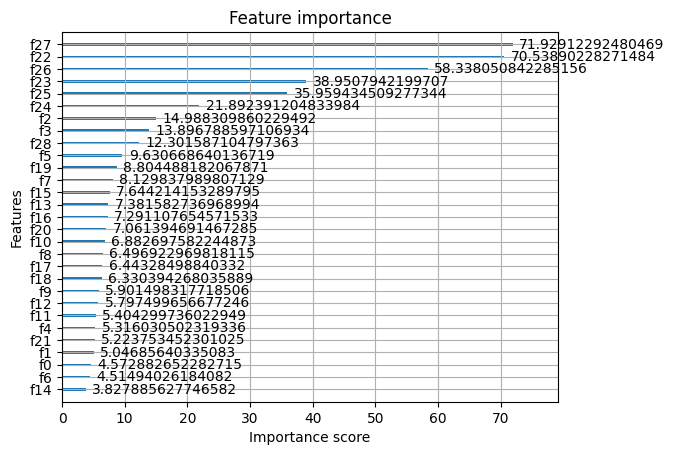

In [10]:
plot_importance(model.xgb_model, importance_type='gain')  # can also be 'weight', 'cover', 'total_gain', etc.
plt.show()

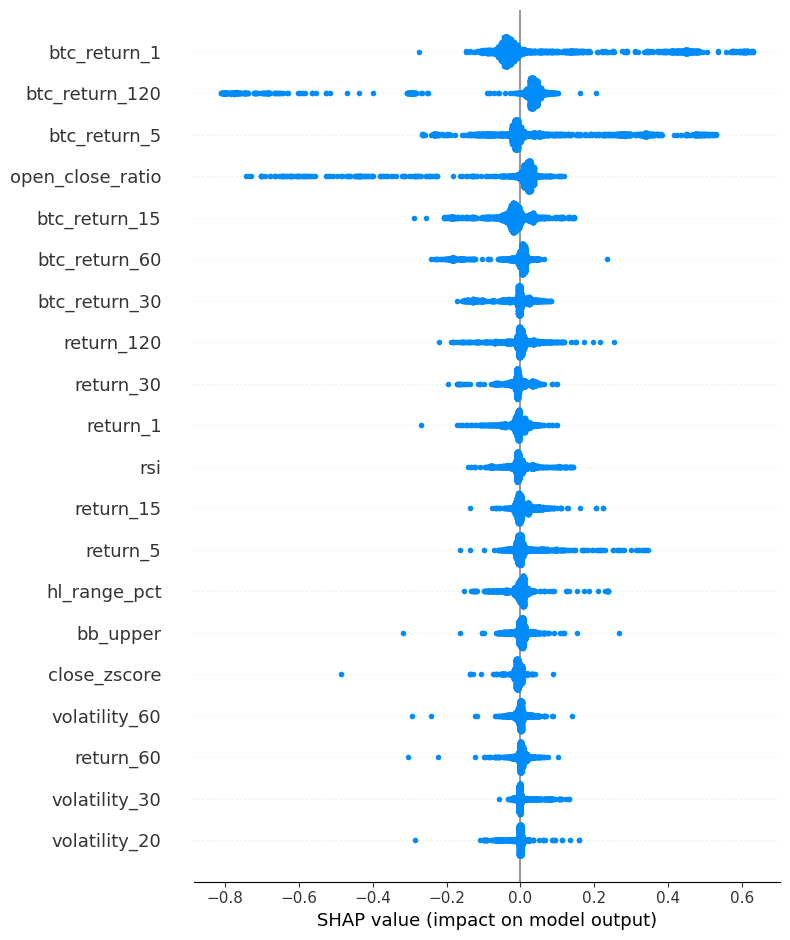

In [11]:
explainer = shap.Explainer(model.xgb_model)
shap_values = explainer(train_df[[c for c in train_df.columns if not c.startswith('label_') and c != 'symbol']])

shap.summary_plot(shap_values, [[c for c in train_df.columns if not c.startswith('label_') and c != 'symbol']])

In [12]:
# Example usage:
if 'combined_validation_df' in locals():
    # Calculate with different thresholds for comparison
    trade_results_conservative = ml_trading.machine_learning.util.calculate_trade_returns(combined_validation_df, threshold=0.8)
    trade_results = ml_trading.machine_learning.util.calculate_trade_returns(combined_validation_df)
    trade_results_aggressive = ml_trading.machine_learning.util.calculate_trade_returns(combined_validation_df, threshold=0.5)
#'''


Trade statistics (threshold=0.8):
Total trades: 104
Average return per trade: 0.4808
Win rate: 72.12%, loss: 24.04%, draw: 3.85%
Total return: 50.0000

Trade statistics (threshold=0.7):
Total trades: 161
Average return per trade: 0.4099
Win rate: 68.32%, loss: 27.33%, draw: 4.35%
Total return: 66.0000

Trade statistics (threshold=0.5):
Total trades: 391
Average return per trade: 0.3018
Win rate: 60.61%, loss: 30.43%, draw: 8.95%
Total return: 118.0000


In [6]:

import ml_trading.models.non_sequential.xgboost_model
import ml_trading.models.non_sequential.mlp_deep_model

metrics_list = []
validaiton_timerange_strs = []
all_validation_dfs = []

for i, (train_df, validation_df, test_df) in enumerate(data_sets):
    print(f"\n########################################################")
    print(f"Training model {i+1} of {len(data_sets)}")
    print(f'train: {len(train_df)}, {train_df.head(1).index[0].strftime("%Y-%m-%d %H:%M:%S")} - {train_df.tail(1).index[0].strftime("%Y-%m-%d %H:%M:%S")}')
    print(f'validation: {len(validation_df)}, {validation_df.head(1).index[0].strftime("%Y-%m-%d %H:%M:%S")} - {validation_df.tail(1).index[0].strftime("%Y-%m-%d %H:%M:%S")}')
    validaiton_timerange_strs.append(f'{validation_df.head(1).index[0].strftime("%Y-%m-%d %H:%M:%S")} - {validation_df.tail(1).index[0].strftime("%Y-%m-%d %H:%M:%S")}')
    #print(f'test: {len(test_df)}\n{test_df.head(1).index}\n{test_df.tail(1).index}')

    target_column='label_long_tp30_sl30_10m'
    #'''
    model, metrics, validation_y_df = ml_trading.models.non_sequential.xgboost_model.train_xgboost_model(
        #ml_data_df, 
        train_df=train_df,
        validation_df=validation_df,
        target_column=target_column,
        prediction_threshold=0.70)
    #'''

    '''
    model, metrics, validation_y_df = ml_trading.models.deep_model.train_mlp_model(
        #ml_data_df, 
        train_df=train_df,
        validation_df=validation_df,
        target_column=target_column,
        use_scaler=True,
        use_norm=False,
        prediction_threshold=0.50)
    #'''

    #model.save("xgboost_model")

    metrics_list.append(metrics)
    validation_y_df['model_num'] = i+1
    all_validation_dfs.append(validation_y_df)

# Print metrics summary
for i, (timerange_str, metrics) in enumerate(zip(validaiton_timerange_strs, metrics_list)):
    print(f"{i+1}, {timerange_str}, non_zero_accuracy: {metrics['non_zero_accuracy']:.2f} (out of {metrics['non_zero_predictions']})")

combined_validation_df = ml_trading.machine_learning.util.combine_validation_dfs(all_validation_dfs)

# Example usage:
if 'combined_validation_df' in locals():
    # Calculate with different thresholds for comparison
    trade_results_conservative = ml_trading.machine_learning.util.calculate_trade_returns(combined_validation_df, threshold=0.8)
    trade_results = ml_trading.machine_learning.util.calculate_trade_returns(combined_validation_df)
    trade_results_aggressive = ml_trading.machine_learning.util.calculate_trade_returns(combined_validation_df, threshold=0.5)
#'''

print('done')




########################################################
Training model 1 of 26
train: 3708, 2024-01-01 00:28:00 - 2024-05-30 01:26:00
validation: 300, 2024-05-31 12:01:00 - 2024-06-07 15:04:00

Test set target label distribution:
Total samples: 300, Positive returns: 157 (52.33%), Negative returns: 98 (32.67%), Neutral returns: 45 (15.00%)

=== Recall Breakdown (by actual label) ===

Total positive labels: 157
Predicted as positive: 16 (10.19%)
Predicted as neutral: 140 (89.17%)
Predicted as negative: 1 (0.64%)


Total neutral labels: 45
Predicted as positive: 3 (6.67%)
Predicted as neutral: 42 (93.33%)
Predicted as negative: 0 (0.00%)


Total negative labels: 98
Predicted as positive: 10 (10.20%)
Predicted as neutral: 88 (89.80%)
Predicted as negative: 0 (0.00%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 29
Actually positive: 16 (55.17%)
Actually neutral: 3 (10.34%)
Actually negative: 10 (34.48%)


Total neutral predictions: 270
Actually positive: 140

/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:80: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_decision < 0) & (y_test < 0)) / np.sum(y_pred_decision < 0),



=== Recall Breakdown (by actual label) ===

Total positive labels: 207
Predicted as positive: 8 (3.86%)
Predicted as neutral: 189 (91.30%)
Predicted as negative: 10 (4.83%)


Total neutral labels: 53
Predicted as positive: 0 (0.00%)
Predicted as neutral: 53 (100.00%)
Predicted as negative: 0 (0.00%)


Total negative labels: 40
Predicted as positive: 1 (2.50%)
Predicted as neutral: 38 (95.00%)
Predicted as negative: 1 (2.50%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 9
Actually positive: 8 (88.89%)
Actually neutral: 0 (0.00%)
Actually negative: 1 (11.11%)


Total neutral predictions: 280
Actually positive: 189 (67.50%)
Actually neutral: 53 (18.93%)
Actually negative: 38 (13.57%)


Total negative predictions: 11
Actually positive: 10 (90.91%)
Actually neutral: 0 (0.00%)
Actually negative: 1 (9.09%)

accuracy: 0.21
mae: 0.97
mse: 1.19
negative_precision: 0.09
negative_recall: 0.03
neutral_precision: 0.19
neutral_recall: 1.00
non_zero_accuracy: 0.45
non_ze

/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:80: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_decision < 0) & (y_test < 0)) / np.sum(y_pred_decision < 0),
/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:80: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_decision < 0) & (y_test < 0)) / np.sum(y_pred_decision < 0),



=== Recall Breakdown (by actual label) ===

Total positive labels: 71
Predicted as positive: 1 (1.41%)
Predicted as neutral: 70 (98.59%)
Predicted as negative: 0 (0.00%)


Total neutral labels: 157
Predicted as positive: 0 (0.00%)
Predicted as neutral: 157 (100.00%)
Predicted as negative: 0 (0.00%)


Total negative labels: 72
Predicted as positive: 0 (0.00%)
Predicted as neutral: 72 (100.00%)
Predicted as negative: 0 (0.00%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 1
Actually positive: 1 (100.00%)
Actually neutral: 0 (0.00%)
Actually negative: 0 (0.00%)


Total neutral predictions: 299
Actually positive: 70 (23.41%)
Actually neutral: 157 (52.51%)
Actually negative: 72 (24.08%)


Total negative predictions: 0
accuracy: 0.53
mae: 0.48
mse: 0.47
negative_precision: nan
negative_recall: 0.00
neutral_precision: 0.53
neutral_recall: 1.00
non_zero_accuracy: 1.00
non_zero_predictions: 1.00
positive_precision: 1.00
positive_recall: 0.01
r2: 0.02

#############

/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:80: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_decision < 0) & (y_test < 0)) / np.sum(y_pred_decision < 0),
/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:76: RuntimeWarning: invalid value encountered in scalar divide
  'positive_precision': np.sum((y_pred_decision > 0) & (y_test > 0)) / np.sum(y_pred_decision > 0),
/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:80: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_decision < 0) & (y_test < 0)) / np.sum(y_pred_decision < 0),



=== Recall Breakdown (by actual label) ===

Total positive labels: 84
Predicted as positive: 0 (0.00%)
Predicted as neutral: 84 (100.00%)
Predicted as negative: 0 (0.00%)


Total neutral labels: 123
Predicted as positive: 0 (0.00%)
Predicted as neutral: 123 (100.00%)
Predicted as negative: 0 (0.00%)


Total negative labels: 93
Predicted as positive: 0 (0.00%)
Predicted as neutral: 93 (100.00%)
Predicted as negative: 0 (0.00%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 0

Total neutral predictions: 300
Actually positive: 84 (28.00%)
Actually neutral: 123 (41.00%)
Actually negative: 93 (31.00%)


Total negative predictions: 0
accuracy: 0.41
mae: 0.60
mse: 0.59
negative_precision: nan
negative_recall: 0.00
neutral_precision: 0.41
neutral_recall: 1.00
non_zero_accuracy: 0.00
non_zero_predictions: 0.00
positive_precision: nan
positive_recall: 0.00
r2: 0.00

########################################################
Training model 9 of 26
train: 3708, 2024-03-2

/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:76: RuntimeWarning: invalid value encountered in scalar divide
  'positive_precision': np.sum((y_pred_decision > 0) & (y_test > 0)) / np.sum(y_pred_decision > 0),
/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:80: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_decision < 0) & (y_test < 0)) / np.sum(y_pred_decision < 0),
/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:76: RuntimeWarning: invalid value encountered in scalar divide
  'positive_precision': np.sum((y_pred_decision > 0) & (y_test > 0)) / np.sum(y_pred_decision > 0),



=== Recall Breakdown (by actual label) ===

Total positive labels: 100
Predicted as positive: 0 (0.00%)
Predicted as neutral: 99 (99.00%)
Predicted as negative: 1 (1.00%)


Total neutral labels: 129
Predicted as positive: 0 (0.00%)
Predicted as neutral: 129 (100.00%)
Predicted as negative: 0 (0.00%)


Total negative labels: 71
Predicted as positive: 0 (0.00%)
Predicted as neutral: 71 (100.00%)
Predicted as negative: 0 (0.00%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 0

Total neutral predictions: 299
Actually positive: 99 (33.11%)
Actually neutral: 129 (43.14%)
Actually negative: 71 (23.75%)


Total negative predictions: 1
Actually positive: 1 (100.00%)
Actually neutral: 0 (0.00%)
Actually negative: 0 (0.00%)

accuracy: 0.43
mae: 0.58
mse: 0.59
negative_precision: 0.00
negative_recall: 0.00
neutral_precision: 0.43
neutral_recall: 1.00
non_zero_accuracy: 0.00
non_zero_predictions: 1.00
positive_precision: nan
positive_recall: 0.00
r2: -0.05

###########

/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:80: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_decision < 0) & (y_test < 0)) / np.sum(y_pred_decision < 0),



=== Recall Breakdown (by actual label) ===

Total positive labels: 50
Predicted as positive: 4 (8.00%)
Predicted as neutral: 46 (92.00%)
Predicted as negative: 0 (0.00%)


Total neutral labels: 126
Predicted as positive: 0 (0.00%)
Predicted as neutral: 126 (100.00%)
Predicted as negative: 0 (0.00%)


Total negative labels: 124
Predicted as positive: 1 (0.81%)
Predicted as neutral: 123 (99.19%)
Predicted as negative: 0 (0.00%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 5
Actually positive: 4 (80.00%)
Actually neutral: 0 (0.00%)
Actually negative: 1 (20.00%)


Total neutral predictions: 295
Actually positive: 46 (15.59%)
Actually neutral: 126 (42.71%)
Actually negative: 123 (41.69%)


Total negative predictions: 0
accuracy: 0.43
mae: 0.63
mse: 0.67
negative_precision: nan
negative_recall: 0.00
neutral_precision: 0.43
neutral_recall: 1.00
non_zero_accuracy: 0.80
non_zero_predictions: 5.00
positive_precision: 0.80
positive_recall: 0.08
r2: -0.30

##########

/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:80: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_decision < 0) & (y_test < 0)) / np.sum(y_pred_decision < 0),



=== Recall Breakdown (by actual label) ===

Total positive labels: 100
Predicted as positive: 1 (1.00%)
Predicted as neutral: 99 (99.00%)
Predicted as negative: 0 (0.00%)


Total neutral labels: 129
Predicted as positive: 0 (0.00%)
Predicted as neutral: 129 (100.00%)
Predicted as negative: 0 (0.00%)


Total negative labels: 71
Predicted as positive: 1 (1.41%)
Predicted as neutral: 70 (98.59%)
Predicted as negative: 0 (0.00%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 2
Actually positive: 1 (50.00%)
Actually neutral: 0 (0.00%)
Actually negative: 1 (50.00%)


Total neutral predictions: 298
Actually positive: 99 (33.22%)
Actually neutral: 129 (43.29%)
Actually negative: 70 (23.49%)


Total negative predictions: 0
accuracy: 0.43
mae: 0.56
mse: 0.54
negative_precision: nan
negative_recall: 0.00
neutral_precision: 0.43
neutral_recall: 1.00
non_zero_accuracy: 0.50
non_zero_predictions: 2.00
positive_precision: 0.50
positive_recall: 0.01
r2: 0.04

#############

/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:80: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_decision < 0) & (y_test < 0)) / np.sum(y_pred_decision < 0),
/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:80: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_decision < 0) & (y_test < 0)) / np.sum(y_pred_decision < 0),



=== Recall Breakdown (by actual label) ===

Total positive labels: 57
Predicted as positive: 1 (1.75%)
Predicted as neutral: 56 (98.25%)
Predicted as negative: 0 (0.00%)


Total neutral labels: 180
Predicted as positive: 0 (0.00%)
Predicted as neutral: 180 (100.00%)
Predicted as negative: 0 (0.00%)


Total negative labels: 63
Predicted as positive: 0 (0.00%)
Predicted as neutral: 63 (100.00%)
Predicted as negative: 0 (0.00%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 1
Actually positive: 1 (100.00%)
Actually neutral: 0 (0.00%)
Actually negative: 0 (0.00%)


Total neutral predictions: 299
Actually positive: 56 (18.73%)
Actually neutral: 180 (60.20%)
Actually negative: 63 (21.07%)


Total negative predictions: 0
accuracy: 0.60
mae: 0.45
mse: 0.44
negative_precision: nan
negative_recall: 0.00
neutral_precision: 0.60
neutral_recall: 1.00
non_zero_accuracy: 1.00
non_zero_predictions: 1.00
positive_precision: 1.00
positive_recall: 0.02
r2: -0.10

############

/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:80: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_decision < 0) & (y_test < 0)) / np.sum(y_pred_decision < 0),



=== Recall Breakdown (by actual label) ===

Total positive labels: 84
Predicted as positive: 0 (0.00%)
Predicted as neutral: 84 (100.00%)
Predicted as negative: 0 (0.00%)


Total neutral labels: 154
Predicted as positive: 0 (0.00%)
Predicted as neutral: 154 (100.00%)
Predicted as negative: 0 (0.00%)


Total negative labels: 62
Predicted as positive: 1 (1.61%)
Predicted as neutral: 61 (98.39%)
Predicted as negative: 0 (0.00%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 1
Actually positive: 0 (0.00%)
Actually neutral: 0 (0.00%)
Actually negative: 1 (100.00%)


Total neutral predictions: 299
Actually positive: 84 (28.09%)
Actually neutral: 154 (51.51%)
Actually negative: 61 (20.40%)


Total negative predictions: 0
accuracy: 0.51
mae: 0.54
mse: 0.52
negative_precision: nan
negative_recall: 0.00
neutral_precision: 0.52
neutral_recall: 1.00
non_zero_accuracy: 0.00
non_zero_predictions: 1.00
positive_precision: 0.00
positive_recall: 0.00
r2: -0.09

############

/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:80: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_decision < 0) & (y_test < 0)) / np.sum(y_pred_decision < 0),
/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:76: RuntimeWarning: invalid value encountered in scalar divide
  'positive_precision': np.sum((y_pred_decision > 0) & (y_test > 0)) / np.sum(y_pred_decision > 0),
/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:80: RuntimeWarning: invalid value encountered in scalar divide
  'negative_precision': np.sum((y_pred_decision < 0) & (y_test < 0)) / np.sum(y_pred_decision < 0),



=== Recall Breakdown (by actual label) ===

Total positive labels: 73
Predicted as positive: 0 (0.00%)
Predicted as neutral: 73 (100.00%)
Predicted as negative: 0 (0.00%)


Total neutral labels: 157
Predicted as positive: 0 (0.00%)
Predicted as neutral: 157 (100.00%)
Predicted as negative: 0 (0.00%)


Total negative labels: 70
Predicted as positive: 0 (0.00%)
Predicted as neutral: 68 (97.14%)
Predicted as negative: 2 (2.86%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 0

Total neutral predictions: 298
Actually positive: 73 (24.50%)
Actually neutral: 157 (52.68%)
Actually negative: 68 (22.82%)


Total negative predictions: 2
Actually positive: 0 (0.00%)
Actually neutral: 0 (0.00%)
Actually negative: 2 (100.00%)

accuracy: 0.53
mae: 0.49
mse: 0.49
negative_precision: 1.00
negative_recall: 0.03
neutral_precision: 0.53
neutral_recall: 1.00
non_zero_accuracy: 1.00
non_zero_predictions: 2.00
positive_precision: nan
positive_recall: 0.00
r2: -0.02

############

/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:76: RuntimeWarning: invalid value encountered in scalar divide
  'positive_precision': np.sum((y_pred_decision > 0) & (y_test > 0)) / np.sum(y_pred_decision > 0),



=== Recall Breakdown (by actual label) ===

Total positive labels: 74
Predicted as positive: 1 (1.35%)
Predicted as neutral: 73 (98.65%)
Predicted as negative: 0 (0.00%)


Total neutral labels: 149
Predicted as positive: 0 (0.00%)
Predicted as neutral: 149 (100.00%)
Predicted as negative: 0 (0.00%)


Total negative labels: 77
Predicted as positive: 0 (0.00%)
Predicted as neutral: 76 (98.70%)
Predicted as negative: 1 (1.30%)


=== Precision Breakdown (by prediction) ===

Total positive predictions: 1
Actually positive: 1 (100.00%)
Actually neutral: 0 (0.00%)
Actually negative: 0 (0.00%)


Total neutral predictions: 298
Actually positive: 73 (24.50%)
Actually neutral: 149 (50.00%)
Actually negative: 76 (25.50%)


Total negative predictions: 1
Actually positive: 0 (0.00%)
Actually neutral: 0 (0.00%)
Actually negative: 1 (100.00%)

accuracy: 0.50
mae: 0.53
mse: 0.52
negative_precision: 1.00
negative_recall: 0.01
neutral_precision: 0.50
neutral_recall: 1.00
non_zero_accuracy: 1.00
non_zero

/Users/junlim/projects/ml_trading/ml_trading/machine_learning/util.py:76: RuntimeWarning: invalid value encountered in scalar divide
  'positive_precision': np.sum((y_pred_decision > 0) & (y_test > 0)) / np.sum(y_pred_decision > 0),


In [40]:
train_df, validation_df, test_df = data_sets[3]

In [42]:
train_df[
  (train_df.index.get_level_values("timestamp") >= "2024-06-16") & 
  (train_df.index.get_level_values("timestamp") <= "2024-06-19") &
  (train_df.symbol == "THETA-USDT-SWAP")
]

,symbol,return_1,return_5,return_15,return_30,return_60,return_120,volatility_5,volatility_10,volatility_20,...,btc_return_30,btc_return_60,btc_return_120,garch_volatility,label_forward_return_2m,label_forward_return_10m,label_long_tp30_sl30_2m,label_short_tp30_sl30_2m,label_long_tp30_sl30_10m,label_short_tp30_sl30_10m
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-06-17 21:43:00-04:00,THETA-USDT-SWAP,-0.051068,-0.089161,-0.089222,-0.111213,-0.106346,-0.121815,2.750855,1.664243,0.932837,...,-0.014017,-0.021103,-0.024977,425.988485,0.008416,0.028938,0.0,0.0,1.0,-1.0


In [56]:
df_raw = pd.read_parquet("2024_06_17.parquet")

In [61]:
df_raw[
  (df_raw.symbol == "THETA-USDT-SWAP")
].head(5)

,symbol,open,high,low,close,volume
timestamp,,,,,,
2024-06-17 00:00:00-04:00,THETA-USDT-SWAP,1.6226,1.6252,1.6217,1.6217,2063.0
2024-06-17 00:01:00-04:00,THETA-USDT-SWAP,1.6215,1.6242,1.6208,1.6236,7005.0
2024-06-17 00:02:00-04:00,THETA-USDT-SWAP,1.6239,1.6248,1.6227,1.6229,2161.0
2024-06-17 00:03:00-04:00,THETA-USDT-SWAP,1.6233,1.6243,1.6199,1.6199,3705.0
2024-06-17 00:04:00-04:00,THETA-USDT-SWAP,1.6196,1.6209,1.6183,1.6183,4566.0


In [66]:
df_raw[
  (df_raw.open == 1.6212) & 
  (df_raw.volume == 1422)
].head(5)

,symbol,open,high,low,close,volume
timestamp,,,,,,
2024-06-17 02:01:00-04:00,THETA-USDT-SWAP,1.6212,1.6212,1.6193,1.62,1422.0


In [67]:
df_raw[
  (df_raw.index.get_level_values("timestamp") >= "2024-06-17 02:00:00-04:00") & 
  (df_raw.index.get_level_values("timestamp") <= "2024-06-17 02:02:00-04:00") &
  (df_raw.symbol == "THETA-USDT-SWAP")
]

,symbol,open,high,low,close,volume
timestamp,,,,,,
2024-06-17 02:00:00-04:00,THETA-USDT-SWAP,1.6232,1.6238,1.6212,1.6221,6558.0
2024-06-17 02:01:00-04:00,THETA-USDT-SWAP,1.6212,1.6212,1.6193,1.6200,1422.0
2024-06-17 02:02:00-04:00,THETA-USDT-SWAP,1.6199,1.6213,1.6184,1.6201,2894.0


In [59]:
df_raw[
  (df_raw.index.get_level_values("timestamp") >= "2024-06-17 21:40:00-04:00") & 
  (df_raw.index.get_level_values("timestamp") <= "2024-06-17 21:44:00-04:00") &
  (df_raw.symbol == "THETA-USDT-SWAP")
]

,symbol,open,high,low,close,volume
timestamp,,,,,,
2024-06-17 21:40:00-04:00,THETA-USDT-SWAP,1.4825,1.4858,1.4810,1.4821,4696.0
2024-06-17 21:41:00-04:00,THETA-USDT-SWAP,1.4813,1.4815,1.4373,1.4412,357903.0
2024-06-17 21:42:00-04:00,THETA-USDT-SWAP,1.4410,1.4414,1.4012,1.4275,691389.0
2024-06-17 21:43:00-04:00,THETA-USDT-SWAP,1.4279,1.4289,1.3534,1.3546,712021.0
2024-06-17 21:44:00-04:00,THETA-USDT-SWAP,1.3546,1.3861,1.3219,1.3672,1093341.0


In [60]:
df_raw[
  (df_raw.index.get_level_values("timestamp") >= "2024-06-17 20:40:00-04:00") & 
  (df_raw.index.get_level_values("timestamp") <= "2024-06-17 20:44:00-04:00") &
  (df_raw.symbol == "THETA-USDT-SWAP")
]

,symbol,open,high,low,close,volume
timestamp,,,,,,
2024-06-17 20:40:00-04:00,THETA-USDT-SWAP,1.5151,1.5213,1.5149,1.5201,8596.0
2024-06-17 20:41:00-04:00,THETA-USDT-SWAP,1.5200,1.5200,1.5088,1.5089,9186.0
2024-06-17 20:42:00-04:00,THETA-USDT-SWAP,1.5095,1.5133,1.5095,1.5110,12181.0
2024-06-17 20:43:00-04:00,THETA-USDT-SWAP,1.5115,1.5131,1.5046,1.5072,15812.0
2024-06-17 20:44:00-04:00,THETA-USDT-SWAP,1.5077,1.5083,1.5059,1.5061,5002.0


In [13]:
trade_results['date'] = trade_results.index.get_level_values('timestamp').strftime("%Y-%m-%d")

<Axes: xlabel='date'>

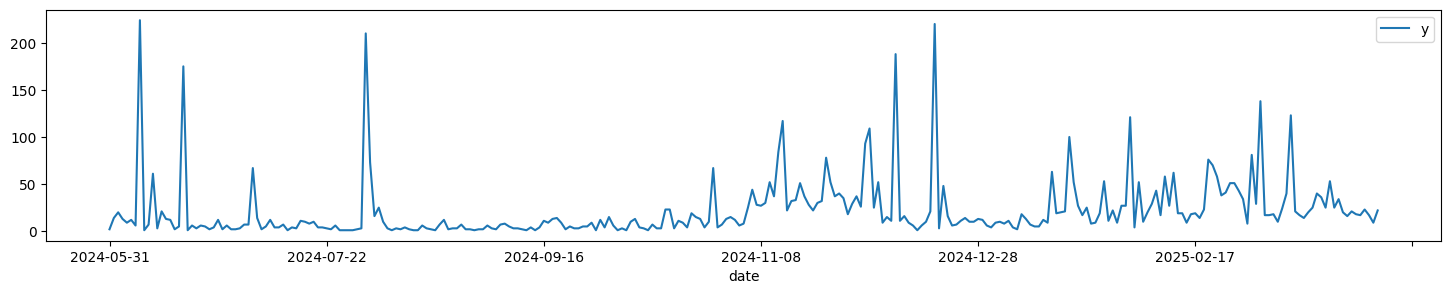

In [14]:
trade_results.groupby(["date"])[["y"]].count().plot(figsize=(18,3))

In [15]:
active_trade_result = trade_results[(trade_results.pred_decision != 0)].groupby(["date"])[["y"]].count()
active_trade_result.index = pd.to_datetime(active_trade_result.index)

<Axes: xlabel='date'>

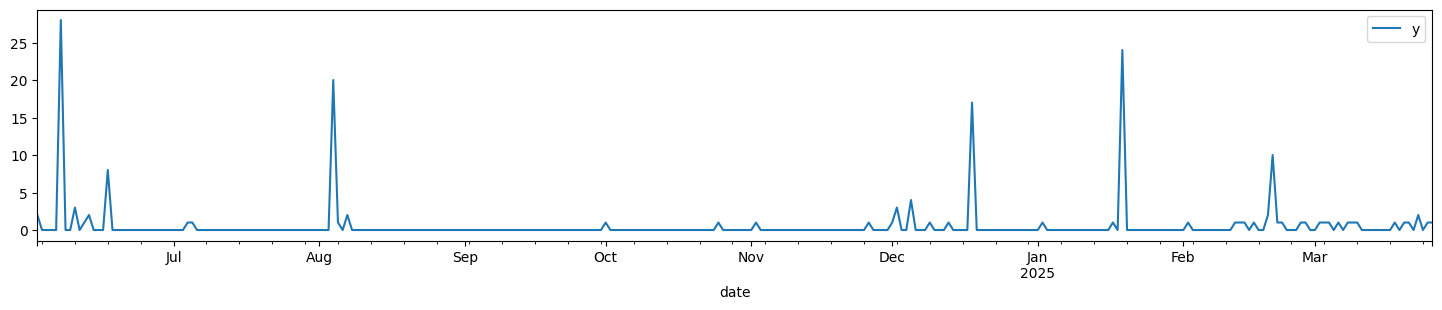

In [16]:
active_trade_result.resample("1d").asfreq().fillna(0).plot(figsize=(18,3))

<Axes: xlabel='timestamp'>

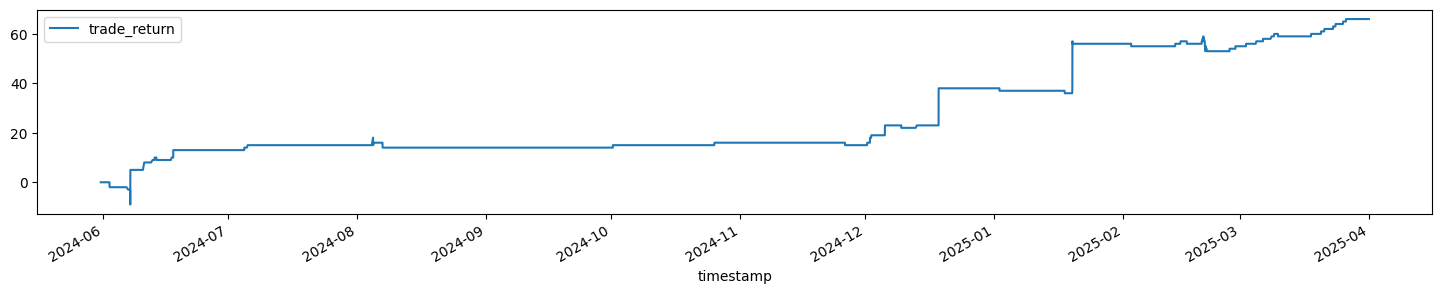

In [17]:
trade_results.groupby(["timestamp"])[["trade_return"]].sum().cumsum().plot(figsize=(18,3))

<Axes: xlabel='timestamp'>

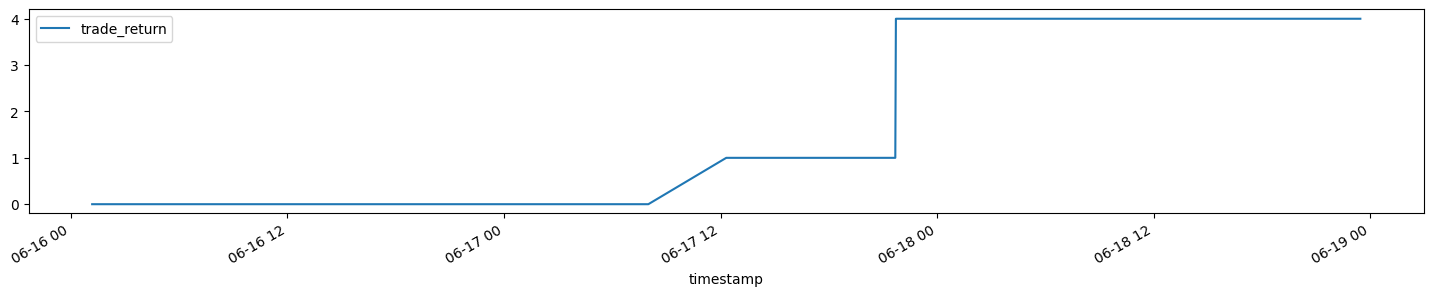

In [68]:
trade_results[
  (trade_results.index.get_level_values("timestamp") >= "2024-06-16") & 
  (trade_results.index.get_level_values("timestamp") <= "2024-06-19")
].groupby(["timestamp"])[["trade_return"]].sum().cumsum().plot(figsize=(18,3))

In [70]:
trade_results[
  (trade_results.index.get_level_values("timestamp") >= "2024-06-17") & 
  (trade_results.index.get_level_values("timestamp") <= "2024-06-18") &
  (trade_results.pred_decision != 0)
].sort_index()

y      pred  model_num  \
timestamp                 symbol                                      
2024-06-17 12:19:00-04:00 ULTI-USDT-SWAP   1.0  0.832758          2   
2024-06-17 21:43:00-04:00 APT-USDT-SWAP   -1.0  0.732001          2   
                          CETUS-USDT-SWAP -1.0  0.714279          2   
                          EOS-USD-SWAP     1.0  0.759449          2   
                          GMX-USDT-SWAP    1.0  0.743908          2   
                          ICP-USDT-SWAP    1.0  0.705809          2   
                          OP-USDT-SWAP     1.0  0.718673          2   
                          THETA-USDT-SWAP  1.0  0.721307          2   

                                           pred_decision  trade_return  \
timestamp                 symbol                                         
2024-06-17 12:19:00-04:00 ULTI-USDT-SWAP             1.0           1.0   
2024-06-17 21:43:00-04:00 APT-USDT-SWAP              1.0          -1.0   
                          CETUS-USDT-SWAP            1.0          -1.0   
                          EOS-USD-SWAP               1.0           1.0   
                          GMX-USDT-SWAP              1.0           1.0   
                          ICP-USDT-SWAP              1.0           1.0   
                          OP-USDT-SWAP               1.0           1.0   
                          THETA-USDT-SWAP            1.0           1.0   

                                                 date  
timestamp                 symbol                       
2024-06-17 12:19:00-04:00 ULTI-USDT-SWAP   2024-06-17  
2024-06-17 21:43:00-04:00 APT-USDT-SWAP    2024-06-17  
                          CETUS-USDT-SWAP  2024-06-17  
                          EOS-USD-SWAP     2024-06-17  
                          GMX-USDT-SWAP    2024-06-17  
                          ICP-USDT-SWAP    2024-06-17  
                          OP-USDT-SWAP     2024-06-17  
                          THETA-USDT-SWAP  2024-06-17

In [54]:
active_trade_result.head()

,y
date,
2024-06-07,33
2024-06-10,1
2024-06-12,1
2024-06-17,21
2024-08-04,32


<Axes: xlabel='timestamp'>

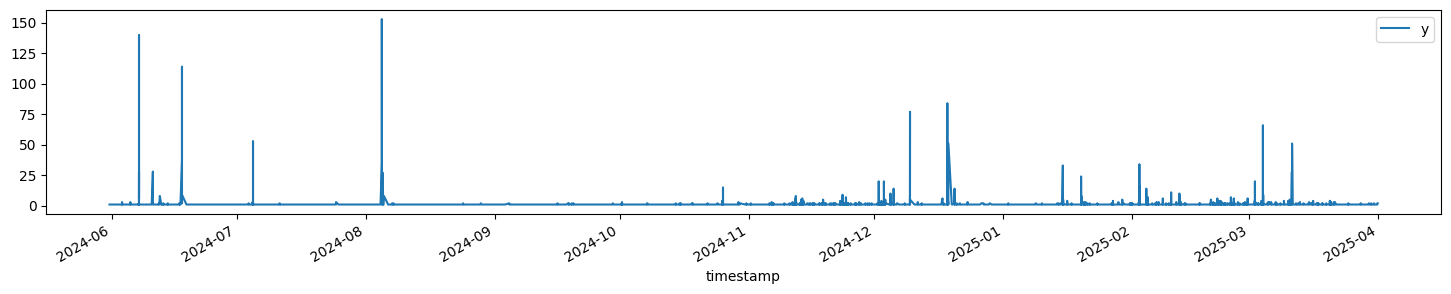

In [212]:
trade_results.groupby(["timestamp"])[["y"]].count().plot(figsize=(18,3))

<Axes: xlabel='timestamp'>

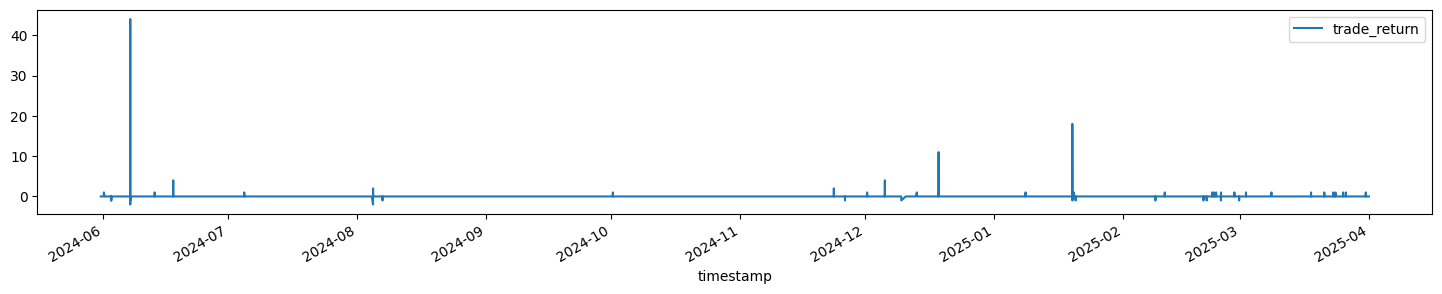

In [213]:
trade_results.groupby(["timestamp"])[["trade_return"]].sum().plot(figsize=(18,3))

<Axes: xlabel='timestamp'>

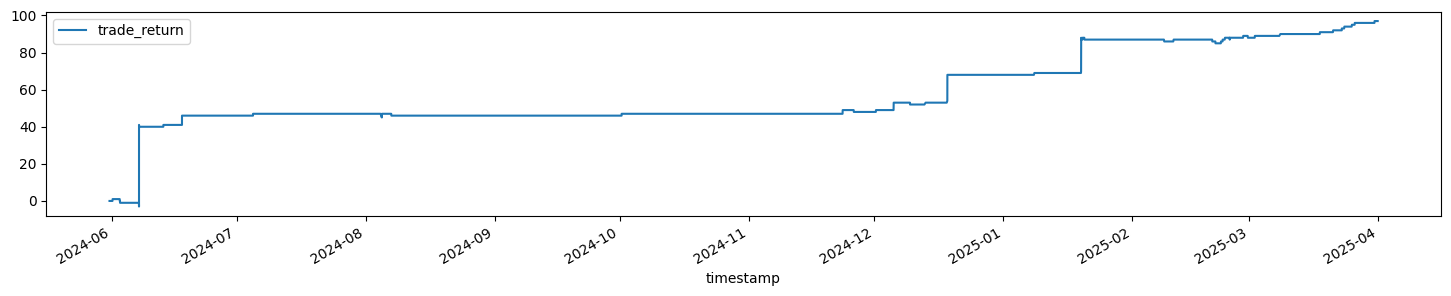

In [214]:
trade_results.groupby(["timestamp"])[["trade_return"]].sum().cumsum().plot(figsize=(18,3))

<Axes: xlabel='timestamp'>

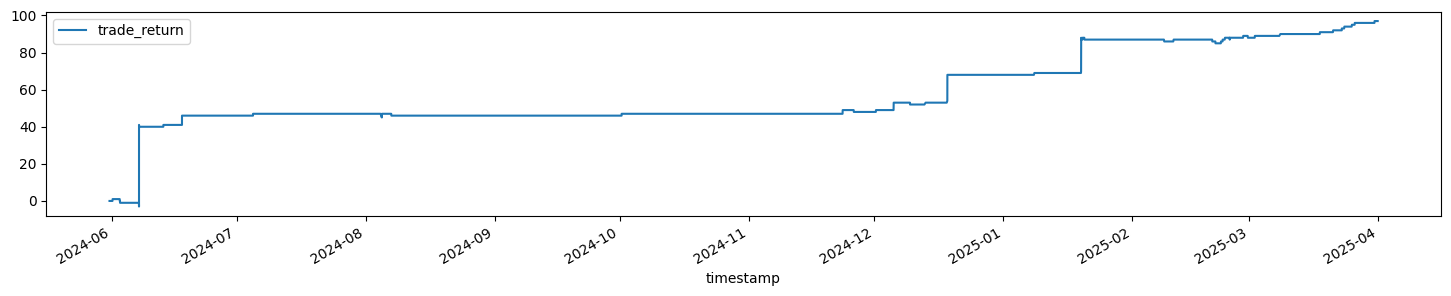

In [216]:
trade_results.groupby(["timestamp"])[["trade_return"]].sum().cumsum().plot(figsize=(18,3))

In [13]:
trade_results_df = pd.read_parquet('trade_results_df.parquet')

In [14]:
trade_results_df[
  (trade_results_df.threshold == 0.8)
].sort_values('total_return')

,threshold,total_trades,avg_return,total_return,win_rate,loss_rate,draw_rate,draw_wins,darw_return,feature_column_prefix
2,0.8,245,-0.522449,-128.0,0.138776,0.661224,0.200000,0.163265,-0.323162,btc_return_
4,0.8,135,-0.111111,-15.0,0.266667,0.377778,0.355556,0.437500,-0.047254,volatility_
14,0.8,323,0.018576,6.0,0.287926,0.269350,0.442724,0.545455,0.007429,garch_
20,0.8,343,0.069971,24.0,0.311953,0.241983,0.446064,0.503268,-0.062628,autocorr_lag1
8,0.8,292,0.130137,38.0,0.421233,0.291096,0.287671,0.583333,0.138780,bb_
24,0.8,489,0.079755,39.0,0.372188,0.292434,0.335378,0.554878,0.371191,close_
6,0.8,394,0.111675,44.0,0.426396,0.314721,0.258883,0.460784,0.051880,obv_
12,0.8,266,0.172932,46.0,0.462406,0.289474,0.248120,0.621212,0.190457,volume_ratio_
0,0.8,241,0.253112,61.0,0.585062,0.331950,0.082988,0.550000,-0.003963,return_
10,0.8,303,0.257426,78.0,0.570957,0.313531,0.115512,0.714286,0.208680,ema_


In [19]:
trade_results_df[
  (trade_results_df.threshold == 0.5)
].sort_values('total_return')

,threshold,total_trades,avg_return,total_return,win_rate,loss_rate,draw_rate,draw_wins,darw_return,feature_column_prefix
3,0.5,577,-0.010399,-6.0,0.379549,0.389948,0.230503,0.263158,-0.456890,btc_return_
5,0.5,540,-0.009259,-5.0,0.303704,0.312963,0.383333,0.536232,0.188843,volatility_
15,0.5,782,0.047315,37.0,0.315857,0.268542,0.415601,0.483077,-0.347918,garch_
21,0.5,710,0.056338,40.0,0.311268,0.254930,0.433803,0.509740,0.035806,autocorr_lag1
13,0.5,747,0.101740,76.0,0.392236,0.290495,0.317269,0.540084,0.291256,volume_ratio_
1,0.5,639,0.122066,78.0,0.502347,0.380282,0.117371,0.533333,0.097592,return_
7,0.5,1033,0.088093,91.0,0.376573,0.288480,0.334947,0.491329,0.184899,obv_
9,0.5,798,0.117794,94.0,0.418546,0.300752,0.280702,0.500000,0.065799,bb_
25,0.5,1041,0.098943,103.0,0.370797,0.271854,0.357349,0.532258,0.516311,close_
11,0.5,786,0.136132,107.0,0.487277,0.351145,0.161578,0.629921,0.427140,ema_


In [16]:
trade_results_with_couple_features_df = pd.read_parquet('trade_results_with_couple_features_df.parquet')

In [17]:
trade_results_with_couple_features_df[
  (trade_results_with_couple_features_df.threshold == 0.8)
].sort_values('total_return')

,threshold,total_trades,avg_return,total_return,win_rate,loss_rate,draw_rate,draw_wins,darw_return,feature_column_prefix
28,0.8,194,-0.623711,-121.0,0.164948,0.788660,0.046392,0.555556,0.060201,"btc_return_,bb_"
34,0.8,118,-0.254237,-30.0,0.322034,0.576271,0.101695,0.416667,0.023428,"btc_return_,garch_"
32,0.8,180,-0.150000,-27.0,0.188889,0.338889,0.472222,0.164706,-0.381320,"btc_return_,volume_ratio_"
24,0.8,105,-0.161905,-17.0,0.361905,0.523810,0.114286,0.583333,0.048544,"btc_return_,volatility_"
44,0.8,86,-0.046512,-4.0,0.453488,0.500000,0.046512,0.750000,0.048661,"btc_return_,close_"
...,...,...,...,...,...,...,...,...,...,...
128,0.8,591,0.321489,190.0,0.571912,0.250423,0.177665,0.419048,-0.112143,"garch_,open_close_ratio"
146,0.8,455,0.426374,194.0,0.632967,0.206593,0.160440,0.465753,-0.005805,"open_close_ratio,hl_range_pct"
144,0.8,535,0.370093,198.0,0.600000,0.229907,0.170093,0.461538,0.026864,"open_close_ratio,autocorr_lag1"
126,0.8,651,0.310292,202.0,0.531490,0.221198,0.247312,0.621118,0.614869,"garch_,rsi"


In [18]:
trade_results_with_couple_features_df[
  (trade_results_with_couple_features_df.threshold == 0.5)
].sort_values('total_return')

,threshold,total_trades,avg_return,total_return,win_rate,loss_rate,draw_rate,draw_wins,darw_return,feature_column_prefix
29,0.5,395,-0.243038,-96.0,0.278481,0.521519,0.200000,0.329114,-0.197958,"btc_return_,bb_"
45,0.5,363,-0.253444,-92.0,0.234160,0.487603,0.278237,0.316832,-0.298812,"btc_return_,close_"
33,0.5,385,-0.132468,-51.0,0.267532,0.400000,0.332468,0.234375,-0.497030,"btc_return_,volume_ratio_"
25,0.5,448,-0.062500,-28.0,0.395089,0.457589,0.147321,0.439394,-0.022581,"btc_return_,volatility_"
61,0.5,503,-0.001988,-1.0,0.294235,0.296223,0.409543,0.519417,0.126378,"volatility_,autocorr_lag1"
...,...,...,...,...,...,...,...,...,...,...
147,0.5,886,0.276524,245.0,0.519187,0.242664,0.238149,0.483412,0.026470,"open_close_ratio,hl_range_pct"
129,0.5,1028,0.269455,277.0,0.522374,0.252918,0.224708,0.428571,-0.298180,"garch_,open_close_ratio"
137,0.5,1066,0.262664,280.0,0.506567,0.243902,0.249531,0.552632,0.522187,"rsi,open_close_ratio"
37,0.5,509,0.552063,281.0,0.683694,0.131631,0.184676,0.382979,-0.080647,"btc_return_,rsi"
